In [1]:
from common import Trial
from typing import List
from tqdm import tqdm
import re
import traceback
import numpy as np
import os
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Lambda
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import tensorflow as tf
from keras.callbacks import TensorBoard



Using TensorFlow backend.


In [2]:
channel_map = {'FP1': 0,
 'FP2': 1,
 'F7': 2,
 'F8': 3,
 'AF1': 4,
 'AF2': 5,
 'FZ': 6,
 'F4': 7,
 'F3': 8,
 'FC6': 9,
 'FC5': 10,
 'FC2': 11,
 'FC1': 12,
 'T8': 13,
 'T7': 14,
 'CZ': 15,
 'C3': 16,
 'C4': 17,
 'CP5': 18,
 'CP6': 19,
 'CP1': 20,
 'CP2': 21,
 'P3': 22,
 'P4': 23,
 'PZ': 24,
 'P8': 25,
 'P7': 26,
 'PO2': 27,
 'PO1': 28,
 'O2': 29,
 'O1': 30,
 'X': 31,
 'AF7': 32,
 'AF8': 33,
 'F5': 34,
 'F6': 35,
 'FT7': 36,
 'FT8': 37,
 'FPZ': 38,
 'FC4': 39,
 'FC3': 40,
 'C6': 41,
 'C5': 42,
 'F2': 43,
 'F1': 44,
 'TP8': 45,
 'TP7': 46,
 'AFZ': 47,
 'CP3': 48,
 'CP4': 49,
 'P5': 50,
 'P6': 51,
 'C1': 52,
 'C2': 53,
 'PO7': 54,
 'PO8': 55,
 'FCZ': 56,
 'POZ': 57,
 'OZ': 58,
 'P2': 59,
 'P1': 60,
 'CPZ': 61,
 'nd': 62,
 'Y': 63}

In [3]:
with open('eeg_full/co2a0000364.txt', 'r') as f:
    file_content = f.read()
    
print(file_content[:200])


# co2a0000364.rd
# 120 trials, 64 chans, 416 samples 368 post_stim samples
# 3.906000 msecs uV
# S1 obj , trial 0
# FP1 chan 0
0 FP1 0 -8.921
0 FP1 1 -8.433
0 FP1 2 -2.574
0 FP1 3 5.239
0 FP1 4 11.587


In [4]:
trials = list(filter(lambda string: len(string) > 0, re.split(r'^# co\w{9}.rd', file_content, flags=re.MULTILINE)))
trials[0]

trial = trials[0]
subject_id = file_content[2:13]
if 'a' == subject_id[3]:
    subject_class = 1
elif 'c' == subject_id[3]:
    subject_class = 0
else:
    raise ValueError('Invalid subject class: ' + subject_id)
    
lines = trial.split('\n')
trial_type_str, trial_number = tuple(lines[3].split(' , trial'))
trial_number = int(trial_number)

if trial_type_str == '# S1 obj':
    trial_type = 0
elif trial_type_str == '# S2 match':
    trial_type = 1
elif trial_type_str == '# S2 nomatch':
    trial_type = 2
else:
    raise ValueError('Invalid trial_type_str: ' + trial_type_str)

lines = lines[4:]


In [5]:
measurements = [(channel_map[line.split()[1]], int(line.split()[2]), float(line.split()[3])) for line in lines if len(line) > 0 and line[0] != '#']
measurements = np.array(measurements)

print(measurements)

[[  0.      0.     -8.921]
 [  0.      1.     -8.433]
 [  0.      2.     -2.574]
 ...
 [ 63.    253.     15.849]
 [ 63.    254.     16.337]
 [ 63.    255.     14.872]]


In [6]:
eeg = measurements[:, 2].reshape((64,256))
#eeg = np.array([np.mean(eeg_channel.reshape(-1, 4), axis=1) for eeg_channel in eeg[::1]])
eeg = (eeg - np.min(eeg))/np.ptp(eeg)

In [7]:
eeg

array([[0.33692014, 0.34224039, 0.40611611, ..., 0.48064323, 0.49661488,
        0.52323794],
       [0.44327065, 0.4698937 , 0.49650586, ..., 0.46456255, 0.53908967,
        0.57635323],
       [0.21780322, 0.29766149, 0.44670482, ..., 0.51059144, 0.5584955 ,
        0.57446716],
       ...,
       [0.42896702, 0.42364677, 0.42364677, ..., 0.48220223, 0.47687108,
        0.46623058],
       [0.33713818, 0.34778959, 0.4010139 , ..., 0.48619242, 0.50216408,
        0.52877623],
       [0.37273371, 0.40467702, 0.45259199, ..., 0.60696648, 0.61228673,
        0.59631507]])

In [8]:
Trial(subject_id, subject_class, trial_number, trial_type, eeg)

{
    "subject_id": "co2a0000364",
    "subject_class": 1,
    "trial_number": 0,
    "trial_type": 0,
    "eeg": "[[0.33692014 0.34224039 0.40611611 ... 0.48064323 0.49661488 0.52323794]\n [0.44327065 0.4698937  0.49650586 ... 0.46456255 0.53908967 0.57635323]\n [0.21780322 0.29766149 0.44670482 ... 0.51059144 0.5584955  0.57446716]\n ...\n [0.42896702 0.42364677 0.42364677 ... 0.48220223 0.47687108 0.46623058]\n [0.33713818 0.34778959 0.4010139  ... 0.48619242 0.50216408 0.52877623]\n [0.37273371 0.40467702 0.45259199 ... 0.60696648 0.61228673 0.59631507]]"
}

In [9]:
errors = 0
zeros = 0

def read_trials(eeg_file: str) -> List[Trial]:
    global errors, zeros
    
    with open(eeg_file, 'r') as f:
        file_content = f.read()
        
        subject_id = file_content[2:13]
        if 'a' == subject_id[3]:
            subject_class = 1
        elif 'c' == subject_id[3]:
            subject_class = 0
        else:
            raise ValueError('Invalid subject class: ' + subject_id)
        
        trials = []
        trials_str = list(filter(lambda string: len(string) > 0, re.split(r'^# co\w{9}.rd', file_content, flags=re.MULTILINE)))

        
        for trial in trials_str:
            try:
                lines = list(filter(lambda line: len(line) > 0, map(lambda line: line.strip(), trial.split('\n'))))
                trial_type_str, trial_number = tuple(lines[2].split(', trial'))
                trial_number = int(trial_number)

                if 'err' in trial_type_str:
                    print('Skipping trial |{}| from file |{}| due to error type'.format(trial_number, eeg_file))
                    errors = errors + 1
                    continue
                elif trial_type_str.startswith('# S1 obj'):
                    trial_type = 0
                elif trial_type_str.startswith('# S2 match'):
                    trial_type = 1
                elif trial_type_str.startswith('# S2 nomatch'):
                    trial_type = 2
                else:
                    raise ValueError('Invalid trial_type_str: ' + trial_type_str)

                lines = lines[4:]

                measurements = [(channel_map[line.split()[1]], int(line.split()[2]), float(line.split()[3])) for line in lines if len(line) > 0 and line[0] != '#']
                measurements = np.array(measurements)
                eeg = measurements[:, 2].reshape((64,256))
                #eeg = np.array([np.mean(eeg_channel.reshape(-1, 4), axis=1) for eeg_channel in eeg[::1]])
                eeg = (eeg - np.min(eeg))/np.ptp(eeg)
                

                if np.count_nonzero(eeg) == 0:
                    print('Skipping trial |{}| from file |{}| due to only 0 values'.format(trial_number, eeg_file))
                    zeros = zeros + 1
                    continue
                    
                trials.append(Trial(subject_id, subject_class, trial_number, trial_type, eeg))
            except:
                print(traceback.format_exc())
                print('Error in file: |{}|'.format(eeg_file))
                print('Error for: |{}|'.format(trial))
                print('Error for: |{}|'.format(lines[2]))
                raise
                
            
        return trials


In [10]:
all_trials = []

for file in tqdm(os.listdir('eeg_full')):
    all_trials = all_trials + read_trials('eeg_full/' + file)
    
print('Good trials: {}, Error trials: {}, Zeros trials: {}'.format(len(all_trials), errors, zeros))

  2%|▏         | 2/122 [00:08<07:26,  3.72s/it]

Skipping trial |89| from file |eeg_full/co2c0000362.txt| due to error type


  4%|▍         | 5/122 [00:21<08:26,  4.32s/it]

Skipping trial |5| from file |eeg_full/co2c0000348.txt| due to error type
Skipping trial |109| from file |eeg_full/co2c0000348.txt| due to error type


 10%|▉         | 12/122 [00:50<07:42,  4.21s/it]

Skipping trial |31| from file |eeg_full/co2a0000404.txt| due to error type


 11%|█         | 13/122 [00:54<07:43,  4.25s/it]

Skipping trial |1| from file |eeg_full/co2a0000410.txt| due to error type
Skipping trial |33| from file |eeg_full/co2a0000410.txt| due to error type
Skipping trial |95| from file |eeg_full/co2a0000410.txt| due to error type


 15%|█▍        | 18/122 [01:16<07:22,  4.26s/it]

Skipping trial |3| from file |eeg_full/co2a0000439.txt| due to error type
Skipping trial |77| from file |eeg_full/co2a0000439.txt| due to error type
Skipping trial |99| from file |eeg_full/co2a0000439.txt| due to error type


 16%|█▌        | 19/122 [01:21<07:30,  4.38s/it]

Skipping trial |71| from file |eeg_full/co2a0000411.txt| due to error type


 17%|█▋        | 21/122 [01:30<07:38,  4.54s/it]

Skipping trial |13| from file |eeg_full/co2a0000405.txt| due to error type
Skipping trial |29| from file |eeg_full/co2a0000405.txt| due to error type
Skipping trial |95| from file |eeg_full/co2a0000405.txt| due to error type


 21%|██▏       | 26/122 [01:49<06:07,  3.83s/it]

Skipping trial |95| from file |eeg_full/co2a0000406.txt| due to error type


 22%|██▏       | 27/122 [01:52<05:57,  3.76s/it]

Skipping trial |113| from file |eeg_full/co2a0000406.txt| due to error type
Skipping trial |95| from file |eeg_full/co2a0000412.txt| due to error type


 23%|██▎       | 28/122 [01:57<06:05,  3.88s/it]

Skipping trial |3| from file |eeg_full/co2a0000416.txt| due to error type
Skipping trial |63| from file |eeg_full/co2a0000416.txt| due to error type


 24%|██▍       | 29/122 [02:01<05:59,  3.87s/it]

Skipping trial |7| from file |eeg_full/co2a0000370.txt| due to error type
Skipping trial |17| from file |eeg_full/co2a0000370.txt| due to error type


 25%|██▍       | 30/122 [02:06<06:45,  4.41s/it]

Skipping trial |11| from file |eeg_full/co2a0000364.txt| due to error type


 25%|██▌       | 31/122 [02:10<06:27,  4.26s/it]

Skipping trial |27| from file |eeg_full/co2a0000402.txt| due to error type


 28%|██▊       | 34/122 [02:25<06:57,  4.75s/it]

Skipping trial |3| from file |eeg_full/co2a0000365.txt| due to error type
Skipping trial |75| from file |eeg_full/co2a0000365.txt| due to error type
Skipping trial |97| from file |eeg_full/co2a0000365.txt| due to error type


 29%|██▊       | 35/122 [02:29<06:41,  4.62s/it]

Skipping trial |41| from file |eeg_full/co2a0000403.txt| due to error type
Skipping trial |51| from file |eeg_full/co2a0000403.txt| due to error type
Skipping trial |61| from file |eeg_full/co2a0000403.txt| due to error type
Skipping trial |97| from file |eeg_full/co2a0000403.txt| due to error type
Skipping trial |105| from file |eeg_full/co2a0000403.txt| due to error type


 30%|██▉       | 36/122 [02:33<06:24,  4.48s/it]

Skipping trial |117| from file |eeg_full/co2a0000403.txt| due to error type
Skipping trial |51| from file |eeg_full/co2a0000417.txt| due to error type


 37%|███▋      | 45/122 [03:11<05:47,  4.51s/it]

Skipping trial |27| from file |eeg_full/co2a0000414.txt| due to error type


 39%|███▊      | 47/122 [03:19<05:26,  4.36s/it]

Skipping trial |95| from file |eeg_full/co2a0000428.txt| due to error type


 41%|████      | 50/122 [03:29<04:07,  3.43s/it]

Skipping trial |115| from file |eeg_full/co2a0000425.txt| due to error type
Skipping trial |1| from file |eeg_full/co2a0000419.txt| due to error type
Skipping trial |9| from file |eeg_full/co2a0000419.txt| due to error type


 43%|████▎     | 53/122 [03:45<05:19,  4.63s/it]

Skipping trial |119| from file |eeg_full/co2a0000394.txt| due to error type


 44%|████▍     | 54/122 [03:50<05:26,  4.80s/it]

Skipping trial |35| from file |eeg_full/co2a0000381.txt| due to error type
Skipping trial |61| from file |eeg_full/co2a0000381.txt| due to error type
Skipping trial |63| from file |eeg_full/co2a0000381.txt| due to error type
Skipping trial |71| from file |eeg_full/co2a0000381.txt| due to error type
Skipping trial |91| from file |eeg_full/co2a0000381.txt| due to error type


 45%|████▌     | 55/122 [03:55<05:17,  4.75s/it]

Skipping trial |37| from file |eeg_full/co2a0000418.txt| due to error type
Skipping trial |41| from file |eeg_full/co2a0000418.txt| due to error type
Skipping trial |71| from file |eeg_full/co2a0000418.txt| due to error type
Skipping trial |93| from file |eeg_full/co2a0000418.txt| due to error type


 48%|████▊     | 58/122 [04:09<05:03,  4.75s/it]

Skipping trial |119| from file |eeg_full/co2a0000424.txt| due to error type


 48%|████▊     | 59/122 [04:14<05:02,  4.80s/it]

Skipping trial |17| from file |eeg_full/co2a0000432.txt| due to error type
Skipping trial |27| from file |eeg_full/co2a0000432.txt| due to error type
Skipping trial |47| from file |eeg_full/co2a0000432.txt| due to error type
Skipping trial |63| from file |eeg_full/co2a0000432.txt| due to error type


 49%|████▉     | 60/122 [04:19<04:56,  4.78s/it]

Skipping trial |19| from file |eeg_full/co2a0000426.txt| due to error type
Skipping trial |41| from file |eeg_full/co2a0000426.txt| due to error type
Skipping trial |109| from file |eeg_full/co2a0000426.txt| due to error type


 50%|█████     | 61/122 [04:22<04:17,  4.23s/it]

Skipping trial |21| from file |eeg_full/co2a0000368.txt| due to error type


 54%|█████▍    | 66/122 [04:40<03:30,  3.75s/it]

Skipping trial |25| from file |eeg_full/co2a0000382.txt| due to error type
Skipping trial |39| from file |eeg_full/co2a0000382.txt| due to error type


 56%|█████▌    | 68/122 [04:49<03:38,  4.05s/it]

Skipping trial |5| from file |eeg_full/co2a0000369.txt| due to error type
Skipping trial |7| from file |eeg_full/co2a0000369.txt| due to error type
Skipping trial |49| from file |eeg_full/co2a0000369.txt| due to error type
Skipping trial |69| from file |eeg_full/co2a0000369.txt| due to error type
Skipping trial |79| from file |eeg_full/co2a0000369.txt| due to error type


 57%|█████▋    | 70/122 [04:59<03:53,  4.48s/it]

Skipping trial |3| from file |eeg_full/co2a0000433.txt| due to error type
Skipping trial |11| from file |eeg_full/co2a0000433.txt| due to error type
Skipping trial |33| from file |eeg_full/co2a0000433.txt| due to error type
Skipping trial |41| from file |eeg_full/co2a0000433.txt| due to error type
Skipping trial |59| from file |eeg_full/co2a0000433.txt| due to error type


 58%|█████▊    | 71/122 [05:02<03:34,  4.20s/it]

Skipping trial |21| from file |eeg_full/co2a0000379.txt| due to error type


 61%|██████▏   | 75/122 [05:21<03:25,  4.37s/it]

Skipping trial |77| from file |eeg_full/co2a0000386.txt| due to error type


 62%|██████▏   | 76/122 [05:24<03:04,  4.02s/it]

Skipping trial |113| from file |eeg_full/co2a0000386.txt| due to error type


 64%|██████▍   | 78/122 [05:33<03:09,  4.32s/it]

Skipping trial |17| from file |eeg_full/co2a0000387.txt| due to error type


 67%|██████▋   | 82/122 [05:50<03:00,  4.51s/it]

Skipping trial |75| from file |eeg_full/co2a0000434.txt| due to error type


 68%|██████▊   | 83/122 [05:53<02:43,  4.20s/it]

Skipping trial |3| from file |eeg_full/co2a0000385.txt| due to error type
Skipping trial |9| from file |eeg_full/co2a0000385.txt| due to error type
Skipping trial |97| from file |eeg_full/co2a0000385.txt| due to error type


 70%|██████▉   | 85/122 [06:02<02:40,  4.33s/it]

Skipping trial |25| from file |eeg_full/co2a0000384.txt| due to error type


 70%|███████   | 86/122 [06:08<02:49,  4.72s/it]

Skipping trial |95| from file |eeg_full/co2a0000435.txt| due to error type


 72%|███████▏  | 88/122 [06:18<02:49,  4.97s/it]

Skipping trial |61| from file |eeg_full/co2a0000409.txt| due to error type


 74%|███████▍  | 90/122 [06:28<02:43,  5.12s/it]

Skipping trial |119| from file |eeg_full/co2c0000381.txt| due to error type


 75%|███████▍  | 91/122 [06:33<02:34,  4.97s/it]

Skipping trial |17| from file |eeg_full/co2c0000342.txt| due to error type


 75%|███████▌  | 92/122 [06:38<02:30,  5.01s/it]

Skipping trial |93| from file |eeg_full/co2c0000356.txt| due to error type


 78%|███████▊  | 95/122 [06:51<02:00,  4.45s/it]

Skipping trial |93| from file |eeg_full/co2a0000447.txt| due to error type


 82%|████████▏ | 100/122 [07:12<01:33,  4.26s/it]

Skipping trial |17| from file |eeg_full/co2c0000341.txt| due to error type
Skipping trial |37| from file |eeg_full/co2c0000341.txt| due to error type


 83%|████████▎ | 101/122 [07:16<01:30,  4.30s/it]

Skipping trial |119| from file |eeg_full/co2c0000341.txt| due to error type


 84%|████████▎ | 102/122 [07:20<01:23,  4.16s/it]

Skipping trial |41| from file |eeg_full/co2c0000354.txt| due to error type


 84%|████████▍ | 103/122 [07:24<01:19,  4.16s/it]

Skipping trial |97| from file |eeg_full/co2c0000383.txt| due to error type


 85%|████████▌ | 104/122 [07:29<01:17,  4.32s/it]

Skipping trial |103| from file |eeg_full/co2c0000397.txt| due to error type


 91%|█████████ | 111/122 [07:58<00:45,  4.18s/it]

Skipping trial |55| from file |eeg_full/co2c0000345.txt| due to error type


 93%|█████████▎| 113/122 [08:08<00:40,  4.47s/it]

Skipping trial |9| from file |eeg_full/co2c0000379.txt| due to error type
Skipping trial |113| from file |eeg_full/co2c0000379.txt| due to error type


 96%|█████████▌| 117/122 [08:25<00:21,  4.30s/it]

Skipping trial |51| from file |eeg_full/co2c0000390.txt| due to error type


 98%|█████████▊| 120/122 [08:35<00:07,  3.75s/it]

Skipping trial |93| from file |eeg_full/co2c0000346.txt| due to error type


100%|██████████| 122/122 [08:43<00:00,  3.64s/it]

Good trials: 10962, Error trials: 95, Zeros trials: 0


In [11]:
nans = [trial for trial in all_trials if np.isnan(trial.eeg).any()]

nans

[]

In [12]:
df = pd.DataFrame.from_records([trial.to_dict() for trial in all_trials])
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
sys.getsizeof(df)

1439135312

In [14]:
df.head()

,eeg,subject_class,subject_id,trial_number,trial_type
0,"[[0.4843077242309488, 0.4906365098303678, 0.50...",0,co2c0000381,14,0
1,"[[0.33087005443542256, 0.3605662500380136, 0.3...",1,co2a0000381,73,2
2,"[[0.3334818174455333, 0.4026889122863853, 0.47...",1,co2a0000404,117,1
3,"[[0.15667361215645575, 0.06769871891365141, 0....",1,co2a0000371,8,0
4,"[[0.12987552487261098, 0.11090689021383421, 0....",1,co3a0000456,94,0


In [15]:
df.describe()

,subject_class,trial_number,trial_type
count,10962.000000,10962.000000,10962.000000
mean,0.634465,60.611294,0.749225
std,0.481602,34.155754,0.828051
min,0.000000,0.000000,0.000000
25%,0.000000,32.000000,0.000000
50%,1.000000,61.000000,1.000000
75%,1.000000,90.000000,1.000000
max,1.000000,119.000000,2.000000


In [16]:
print(len(df.loc[df['subject_class'] == 1]))
print(len(df.loc[df['subject_class'] == 0]))


6955
4007


In [17]:
X = df['eeg'].values
y = df['subject_class'].values

# keras required format
X = np.rollaxis(np.dstack(X), -1)
X = X.reshape(X.shape[0], 64, 256, 1)
y = keras.utils.to_categorical(y, 2)

In [18]:
X.shape

(10962, 64, 256, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [20]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


def safe_log(x, eps=1e-6):
    """ Prevents :math:`log(0)` by using :math:`log(max(x, eps))`."""
    return keras.backend.log(keras.backend.clip(x, eps, 100000000))


In [21]:
"""
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 64), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5)
  (conv_classifier): Conv2d(40, 2, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)
"""

input_shape = (64, 256, 1)
num_classes = 2
batch_size=128
epochs=1

model = Sequential()
model.add(Conv2D(40, kernel_size=(1, 25),
                 input_shape=input_shape))
model.add(Conv2D(40, kernel_size=(64, 1)))
model.add(BatchNormalization(momentum=0.1))
model.add(Lambda(lambda x: x ** 2))
model.add(AveragePooling2D(pool_size=(1, 75), strides=(1, 1)))
model.add(Lambda(lambda x: safe_log(x)))
model.add(Dropout(0.5))
model.add(Conv2D(2, kernel_size=(1, 30), dilation_rate=(15, 1)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 232, 40)       1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 232, 40)        102440    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 232, 40)        160       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 232, 40)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 158, 40)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 158, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 158, 40)        0         
__________

In [23]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        
history = AccuracyHistory()



Instructions for updating:
Use tf.cast instead.
Train on 9865 samples, validate on 1097 samples
Epoch 1/1
9865/9865 [==============================] - 205s 21ms/step - loss: 5.1645 - acc: 0.5400 - val_loss: 1.0753 - val_acc: 0.5014
Test loss: 1.0753340335357373
Test accuracy: 0.501367365705391


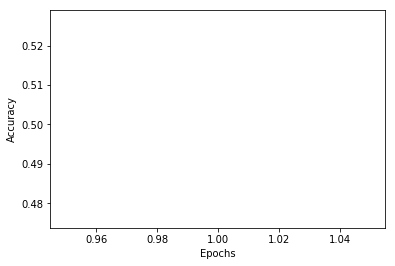

In [24]:
from keras.callbacks import TensorBoard

tensor_board = TensorBoard('./logs/baseline_shallow')



model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history, tensor_board])


score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(range(1,len(history.acc) + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [25]:
import IPython
IPython.display.Audio("F:\\Tresorit\\01 - Startup Screen.mp3", autoplay=True)


ValueError: could not convert string to float: 'F:\\Tresorit\\01 - Startup Screen.mp3'